In [1]:
import seaborn as sns
sns.set()

# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a data set of venue popularities provided by Yelp.  The data set contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. 


## Download and parse the incoming data


In [2]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [4]:
len(data)

37938

In scikit-learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features. Let's get in this habit now, by creating a separate list of the ratings.

In [7]:
star_ratings = [row['stars'] for row in data]

In [11]:
from sklearn.model_selection import train_test_split

data_train, data_test, targets_train, targets_test = train_test_split(data, star_ratings, test_size=0.2, random_state=42)

## Question 2: city_model

Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `fit` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `predict` method can look up the average rating for the city of each record it receives.

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from collections import defaultdict
class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        star_sum = defaultdict(int)
        count = defaultdict(int)
        for row, stars in zip(data, star_ratings):
            star_sum[row['city']]+=stars
            count[row['city']]+=1
        for city in star_sum:
            # calculate average star rating and store in avg_stars
            self.avg_stars[city]=star_sum[city]/count[city]
        return self

    def predict(self, X):
        ans=[]
        for row in X:
            if row['city'] in self.avg_stars:
                ans.append(self.avg_stars[row['city']])
            else:
                ans.append(0)
        return ans

Now we can create an instance of our regressor and train it.

In [15]:
city_model = CityRegressor()
city_model.fit(data_train, targets_train)

CityRegressor()

And let's see if it works.

In [16]:
city_model.predict(data[:10])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75, 3.1, 3.1, 3.1, 3.1, 3.1]

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [16]:
city_model.predict([{'city': 'Phoenix'}, {'city': 'Timbuktu'}, {'city': 'Madison'}])

[3.6702903946388683, 0, 3.6457337883959045]

In [18]:
r_squared = city_model.score(data_train, targets_train)
print(f"R-squared value: {r_squared}")

R-squared value: 0.010825765666394815


## Question 3: lat_long_model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Since we need to select the appropriate columns from our dictionaries to build our latitude-longitude model, we will have to use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). However, the `ColumnTransformer` works with either NumPy arrays or pandas data frames. While we can convert our training data into a data frame easily, the test set the grader uses is a list of dictionaries. Thus, our first estimator in our workflow should be a transformer that converts a list of dictionaries into a pandas data frame.

In [17]:
import pandas as pd
from sklearn.base import TransformerMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self

    def transform(self, X):
        # Return a pandas data frame from X
        return pd.DataFrame(X)

Let's test out the transformer.

Now we are ready to use `ColumnTransformer` and test it out.

In [18]:
import numpy as np
from sklearn.compose import ColumnTransformer

selector = ColumnTransformer(
    [
        ('keep', 'passthrough', ['latitude', 'longitude'])
    ]
)

Now, let's feed the output of the transformer in to a `KNeighborsRegressor`. As a sanity check, we'll test it with the first 5 rows.

We are not ready to submit to the grader; there are two things we still need to do:
1. Wrap all the steps necessary to go from our data (list of dictionaries) to predicted ratings
1. Determine the optimal value for our predictor's hyperparameter

For the first point, we will use a pipeline, ensuring that our model applies all the required transformations given the form of the input data. Remember that a pipeline is made with a list of `(step_name, estimator)` tuples.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

to_data_frame = ToDataFrame()
pipe = Pipeline([
    ('to_dataframe', to_data_frame), 
    ('feature_selection', selector),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])


Now let's fit and predict.

In [20]:
pipe.fit(data_train, targets_train)

Pipeline(steps=[('to_dataframe', ToDataFrame()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('keep', 'passthrough',
                                                  ['latitude', 'longitude'])])),
                ('knn', KNeighborsRegressor())])

In [21]:
r_squared = pipe.score(data_train, targets_train)
print(f"R-squared value: {r_squared}")

R-squared value: 0.2464199119736612


In [22]:
r_squared = pipe.score(data_test, targets_test)
print(f"R-squared value: {r_squared}")

R-squared value: -0.11083913176906046


Let's now focus on the second point. The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction. There is no reason to believe that 5 is the optimum value. We will need to determine a better value for this hyperparameter. A common approach is to use a hyperparameter searching tool such as [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). You may need to refer back to the notebooks about the ways to interface searching tools and pipelines.

You should consider whether the data needs to be shuffled as it might not have been randomized. For example, the data could be ordered by a certain feature or by the labels. If you perform a train/test split with [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), the data is shuffled by default. However, when using `GridSearchCV`, the folds are not shuffled when you use the default K-folds cross-validation.

The code below will plot a rolling mean of the star ratings. Do you need to shuffle the data?

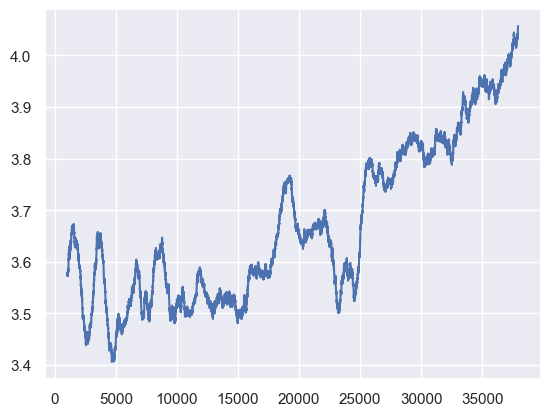

In [47]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

Once you've found a good value of `n_neighbors`, submit the model to the grader. Note, "good" is a relative measure here. The reference solution has an $R^2$ score of only 0.02. There is just rather little signal available for modeling.

In [53]:
from sklearn.model_selection import GridSearchCV,KFold
pipeline=Pipeline([
    ('to_dataframe', to_data_frame),
    ('feature_selection', selector),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': [5,50,80,100,110,120,130] 
}

kf = KFold(n_splits=5, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf) 

grid_search.fit(data, star_ratings)

print("Best n_neighbors:", grid_search.best_params_['knn__n_neighbors'])


Best n_neighbors: 80


In [54]:
lat_long_model=grid_search.best_estimator_

In [55]:
lat_long_model.score(data_train,targets_train)

0.04817658658684931

In [56]:
lat_long_model.score(data_test,targets_test)

0.04270862828463318

## Question 4: category_model

While location is important, we could also try seeing how predictive the
venue's category is. Build an estimator that considers only the `'categories'` field of the data.

The categories come as a list of strings, but the scikit-learn's predictors all need numeric input. We ultimately want to create a column in our feature matrix to represent every category. For a given row, only the columns that represent the categories it contains will be filled with a one, otherwise, it will be filled with a zero. The described method is similar to **one-hot encoding**, however, an observation/row can contain more than one "hot", non-zero, column.

To achieve our encoding plan, we need to use scikit-learn's provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer). This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it. Missing keys are filled with zeros. However, we need to build a transformer that takes an array of strings and returns an array of dictionaries with keys given by those strings and values of one. For example, it should transform `X_in` into `X_out`.

In [23]:
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        return X.apply(lambda x: {item: 1 for item in x})

Now let's test out that our `DictEncoder` works out as expected.

Now, create a pipeline object of the two step transformation for the categories data. Afterwards, create a `ColumnTransformer` object that will use the aforementioned pipeline object to transform the `'categories'` field.

In [24]:
from sklearn.feature_extraction import DictVectorizer
pipeline = Pipeline([
    ('list_to_dict', DictEncoder()),
    ('dict_vectorizer', DictVectorizer(sparse=False))
])


Finally, create a pipeline object that will
1. Convert our list of dictionaries into a data frame
1. Select the `'categories'` column and encode the data
1. Train a regularized linear model such as `Ridge`

There will be a large number of features, one for each category, so there is a significant danger of overfitting. Use cross validation to choose the best regularization parameter.

In [25]:
from sklearn.linear_model import Ridge
cat_selector = ColumnTransformer(
    [
        ('keep', 'passthrough', ['categories'])
    ]
)
class ArrayToSeries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.Series(X.ravel())
pipeline = Pipeline([
    ('to_dataframe', to_data_frame),
    ('feature_selection', cat_selector),
    ('to_pdseries',ArrayToSeries()),
    ('list_to_dict', DictEncoder()),
    ('dict_vectorizer', DictVectorizer(sparse=False)),
    ('ridge', Ridge(alpha=1.0))
])
pipeline.fit(data,star_ratings)

Pipeline(steps=[('to_dataframe', ToDataFrame()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('keep', 'passthrough',
                                                  ['categories'])])),
                ('to_pdseries', ArrayToSeries()),
                ('list_to_dict', DictEncoder()),
                ('dict_vectorizer', DictVectorizer(sparse=False)),
                ('ridge', Ridge())])

In [26]:
pipeline.score(data_train, targets_train)

0.20498543290300364

In [27]:
pipeline.score(data_test, targets_test)

0.20348183839696787

In [74]:
param_grid = {
    'ridge__alpha': [1,10,20, 5, .1]  
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)


grid_search.fit(data, star_ratings)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('to_dataframe', ToDataFrame()),
                                       ('feature_selection',
                                        ColumnTransformer(transformers=[('keep',
                                                                         'passthrough',
                                                                         ['categories'])])),
                                       ('to_pdseries', ArrayToSeries()),
                                       ('list_to_dict', DictEncoder()),
                                       ('dict_vectorizer',
                                        DictVectorizer(sparse=False)),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [1, 10, 20, 5, 0.1]},
             scoring='neg_mean_squared_error', verbose=1)

In [75]:
print(grid_search.best_params_)

{'ridge__alpha': 5}


In [76]:
category_model=grid_search.best_estimator_

In [77]:
category_model.score(data_train, targets_train)

0.2011469349528019

In [78]:
category_model.score(data_test, targets_test)

0.20031214717716384

**Extension:** Some categories (e.g., Restaurants) are not very specific. Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term frequency-inverse document frequency (tf-idf). Add in a [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) between the `DictVectorizer` and the linear model, and see if that improves performance.

## Question 5: attribute_model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```python
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False},
  'Price Range': 3
}
```
We wish to encode them in the same manner as our categories data using the `DictVectorizer`. Before we do so, we need to flatten the dictionary to a single level:
```python
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0,
  'Price Range_3': 1
}
```
Build a custom transformer that flattens the dictionary for the `'attributes'` field. 

In [36]:
for dd in data[:10]:
    print(dd['categories'])

['Doctors', 'Health & Medical']
['Restaurants']
['American (Traditional)', 'Restaurants']
['Food', 'Ice Cream & Frozen Yogurt', 'Fast Food', 'Restaurants']
['Chinese', 'Restaurants']
['Television Stations', 'Mass Media']
['Home Services', 'Heating & Air Conditioning/HVAC']
['Libraries', 'Public Services & Government']
['Veterinarians', 'Pets']
['Bars', 'American (Traditional)', 'Nightlife', 'Lounges', 'Restaurants']


In [79]:
def flatten_dict(d, parent_key='', sep='_'):
    """ 
    Recursively flatten a nested dictionary and concatenate keys.
    """
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            # If v is a simple scalar value and not boolean, append it to the key
            if isinstance(v, (int, float, str)) and not isinstance(v, bool):
                new_key = f"{new_key}_{v}"
                items[new_key] = 1
            else:
                items[new_key] = v
    return items

class AttributeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply the flattening function row-wise
        return X.map(flatten_dict)

We can check that we're getting the right number of columns _after_ vectorization to allow for different ways of constructing this. 

In [80]:
attribute_example = pd.Series([
    {
        'Wi-Fi': 'free',
        'Price Range': 2,
        'Parking': {
            'garage': False,
            'street': True
        }
    },
    {
        'Wi-Fi': 'no',
        'Price Range': 3,
        'Accepts Credit Cards': True,
        'Take-out': False
    },
    {
        'Wi-Fi': 'paid',
        'Parking': {
            'garage': True,
            'valet': True
        },
        'Take-out': True
    }
])

n_columns = 10

test_att_transformer = AttributeTransformer()
dictvect = DictVectorizer()

dictvect.fit(test_att_transformer.fit_transform(attribute_example))


DictVectorizer()

Similar to what was done before, create a model that properly encodes the attribute data and learns to predict the ratings.

You may find it difficult to find a single regressor that does well enough. A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit. Build a custom predictor that takes as an argument two other predictors. It should use the first to fit the raw data and the second to fit the residuals of the first.

In [106]:
# Create the linear + non-linear ensemble predictor
from sklearn.base import BaseEstimator, RegressorMixin, clone

class ResidualRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, first_regressor, second_regressor):
        self.first_regressor = first_regressor
        self.second_regressor = second_regressor

    def fit(self, X, y):
        # Fit the first regressor on the raw data
        self.first_regressor_ = clone(self.first_regressor).fit(X, y)
        
        # Predict and compute residuals
        residuals = y - self.first_regressor_.predict(X)
        
        # Fit the second regressor on residuals
        self.second_regressor_ = clone(self.second_regressor).fit(X, residuals)
        return self

    def predict(self, X):
        # Predict using the first regressor
        first_pred = self.first_regressor_.predict(X)
        
        # Predict the residuals using the second regressor
        residual_pred = self.second_regressor_.predict(X)
        
        # Sum the two predictions
        return first_pred + residual_pred


In [107]:
# Create the attribute model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
att_selector = ColumnTransformer(
    [
        ('keep', 'passthrough', ['attributes'])
    ]
)
# Data preprocessing pipeline
preprocessor = Pipeline([
    ('to_dataframe', to_data_frame),
    ('Attribute_selection',att_selector),
    ('to_pdseries',ArrayToSeries()),
    ('flatten', AttributeTransformer()),
    ('vectorizer', DictVectorizer(sparse=False))
])


In [108]:
# Main pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', ResidualRegressor(Ridge(alpha=1.0), RandomForestRegressor(n_estimators=500)))
])

# Train the model
pipeline.fit(data, star_ratings)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('to_dataframe', ToDataFrame()),
                                 ('Attribute_selection',
                                  ColumnTransformer(transformers=[('keep',
                                                                   'passthrough',
                                                                   ['attributes'])])),
                                 ('to_pdseries', ArrayToSeries()),
                                 ('flatten', AttributeTransformer()),
                                 ('vectorizer',
                                  DictVectorizer(sparse=False))])),
                ('regressor',
                 ResidualRegressor(first_regressor=Ridge(),
                                   second_regressor=RandomForestRegressor(n_estimators=500)))])

In [110]:
r_squared = pipeline.score(data_train, targets_train)
print(f"R-squared value: {r_squared}")

R-squared value: 0.2537965287949535


In [85]:
# Define the parameter grid
param_grid = {
  #  'preprocess__vectorizer__dtype': [int, float],
    'regressor__first_regressor__alpha': [0.5, 1.0, 5.0],  # Ridge regularization parameter
    'regressor__second_regressor__n_estimators': [ 100, 200,500],  # RandomForest number of trees
    'regressor__second_regressor__max_depth': [None, 2, 5,10]  # RandomForest max depth
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)  # n_jobs=-1 uses all cores


In [86]:
# Fit the GridSearchCV instance
grid_search.fit(data, star_ratings)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/qingyunwang/Dropbox/job/TheDataIncubator/notebooks/datacourse_practical-ml-fellowship/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('to_dataframe',
                                                         ToDataFrame()),
                                                        ('Attribute_selection',
                                                         ColumnTransformer(transformers=[('keep',
                                                                                          'passthrough',
                                                                                          ['attributes'])])),
                                                        ('to_pdseries',
                                                         ArrayToSeries()),
                                                        ('flatten',
                                                         AttributeTransformer()),
                                                        ('vectorizer',
                                                         DictVectorizer(sparse=False))])),
                                       ('regressor',
                                        ResidualRegressor(first_regressor=Ridge(),
                                                          second_regressor=RandomForestRegressor(n_estimators=500)))]),
             n_jobs=-1,
             param_grid={'regressor__first_regressor__alpha': [0.5, 1.0, 5.0],
                         'regressor__second_regressor__max_depth': [None, 2, 5,
                                                                    10],
                         'regressor__second_regressor__n_estimators': [100, 200,
                                                                       500]},
             verbose=1)

In [87]:
grid_search.best_params_

{'regressor__first_regressor__alpha': 1.0,
 'regressor__second_regressor__max_depth': 10,
 'regressor__second_regressor__n_estimators': 100}

In [88]:
attribute_model=grid_search.best_estimator_

In [89]:
category_model.score(data_train, targets_train)

0.2011469349528019

In [90]:
category_model.score(data_test, targets_test)

0.20031214717716384

## Question 6: full_model

So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. Build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor should be fit. When `transform` is called, the predictor's `predict` method should be called, and its results returned as the transformation.

Note that the output of the `transform` method should be a 2-D array with a single column in order for it to work well with the scikit-learn pipeline. If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector. If you are just using Python lists, you will want a list of lists of single elements.

In [91]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        # What needs to be done here?
        self.model=model
    
    def fit(self, X, y):
        # Fit the stored predictor.
        # Question: what should be returned?
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.
        return np.array(self.model.predict(X)).reshape(-1, 1)

Let's now test it out on our `city_model`.

In [92]:
city_trans = ModelTransformer(city_model)
city_trans.fit(data, star_ratings)
X_t = city_trans.transform(data[:5])


In [93]:
X_t

array([[3.67029039],
       [3.75      ],
       [3.75      ],
       [3.75      ],
       [3.75      ]])

In [94]:
y_pred = np.array(city_model.predict(data[:5]))


In [95]:
city_model.predict(data[:5])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

In [96]:
y_pred

array([3.67029039, 3.75      , 3.75      , 3.75      , 3.75      ])

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [97]:
from sklearn.pipeline import FeatureUnion

city_trans = ModelTransformer(city_model)
lat_long_trans=ModelTransformer(lat_long_model)
category_trans=ModelTransformer(category_model)
attribute_trans=ModelTransformer(attribute_model)

union = FeatureUnion([
        # FeatureUnion uses the same syntax as Pipeline
        ('cit_trans',city_trans),
        ('lat_long_trans',lat_long_trans),
        ('category_trans',category_trans),
        ('attribute_trans',attribute_trans)
    ])

Our `FeatureUnion` object should return a feature matrix with four columns.

In [98]:
union.fit(data_train, targets_train)
X_t = union.transform(data[:5])


Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [99]:
from sklearn.linear_model import LinearRegression
pipeline=Pipeline(
    [
        ('feature_union',union),
        ('linear_regression',LinearRegression())
    ]
)
full_model=pipeline.fit(data_train, targets_train)

In [103]:
r_squared = full_model.score(data, star_ratings)
print(f"R-squared value: {r_squared}")

R-squared value: 0.24411266811522192


In [105]:
r_squared = full_model.score(data_test, targets_test)
print(f"R-squared value: {r_squared}")

R-squared value: 0.23788043292728434
